In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
rf = {'annual_return': 0.03, 'annual_sigma': 0, 'name': 'risk-free asset'}

In [3]:
from datetime import date
def get_stock_info(ticker, start='1900-01-01', end=str(date.today()), period='M'):
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(start="2000-01-01", end='2022-08-31').reset_index()
    stock_hist['period'] = stock_hist['Date'].dt.to_period(period)
    stock_hist['year'] = stock_hist['Date'].dt.to_period('Y')
    period_return = (stock_hist.groupby('period').last()['Close'] / stock_hist.groupby('period').first()['Open'] - 1)
    num_periods = None
    if period == 'M':
        num_periods = 12
    elif period == 'Y':
        num_periods = 1
    elif period == 'W':
        num_periods = 52
    elif period == 'D':
        num_periods = 260
    
    stock_info = {'annual_return': period_return.mean()*num_periods, 
                  'annual_sigma': period_return.std()*num_periods, 
                  'name': ticker,
                  'returns_per_period': period_return,
                  'num_periods': num_periods
                 }
    return stock_info

def get_portfolio_info(stock1, stock2, cov, alpha):
    assert stock1['num_periods'] == stock2['num_periods'], print("Calculation periods do not match!")
    
    return {
                'annual_return': alpha*stock1['annual_return'] + (1-alpha)*stock2['annual_return'],
                'annual_sigma': np.sqrt((alpha*stock1['annual_sigma'])**2 + ((1-alpha)*stock2['annual_sigma'])**2 + 2*alpha*(1-alpha)*cov),
                'name': f"{stock1['name']}_{stock2['name']}",
                'returns_per_period': alpha * stock1['returns_per_period'] + (1-alpha) * stock2['returns_per_period'],
                'num_periods': stock1['num_periods']
           }

def get_cov(stock1, stock2):
    assert stock1['num_periods'] == stock2['num_periods'], print("Calculation periods do not match!")
    cov_matrix = np.array(stock1['returns_per_period'].reset_index().merge(stock2['returns_per_period'].reset_index(), on='period')[['0_x','0_y']].cov())
    return cov_matrix[0][1]*(stock1['num_periods']**2)

In [4]:
def portfolio_plot(stock1, stock2, cov, ax=None, fig=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(18,12))
    portfolio_returns = []
    portfolio_sigma = []
    slope = []
    alpha_list = np.linspace(-3,3,601)
    for alpha in alpha_list:
        d = get_portfolio_info(stock1, stock2, cov, alpha)
        portfolio_returns.append(d['annual_return'])
        portfolio_sigma.append(d['annual_sigma'])
        slope.append((d['annual_return']-rf['annual_return'])/(d['annual_sigma']-rf['annual_sigma']))
        
    ax.plot(rf['annual_sigma'], rf['annual_return'], marker='o', markersize=5, label=f"{rf['name']}")
    ax.plot(portfolio_sigma, portfolio_returns, label = f"Efficient frontier without risk-free asset: {stock1['name']} and {stock2['name']}")
    
    ax.set_xlabel('annual_sigma')
    ax.set_ylabel('annual_return')
    
    best_alpha = np.clip(alpha_list[np.array(slope).argmax()], 0, 1)
    best_portfolio = get_portfolio_info(stock1, stock2, cov, best_alpha)
    best_slope = (best_portfolio['annual_return'] - rf['annual_return']) / (best_portfolio['annual_sigma'] - rf['annual_sigma'])
    xlim = ax.get_xlim()[1]
    y_xlim = best_slope * (xlim - rf['annual_sigma']) + rf['annual_return']
    
    ax.plot([rf['annual_sigma'], best_portfolio['annual_sigma'], xlim], [rf['annual_return'], best_portfolio['annual_return'], y_xlim]
             , marker='o', markersize=5, label = f"Efficient frontier with risk-free asset: {stock1['name']} and {stock2['name']}")
    ax.plot(stock1['annual_sigma'], stock1['annual_return'], marker='o', markersize=5, label=stock1['name'])
    ax.plot(stock2['annual_sigma'], stock2['annual_return'], marker='o', markersize=5, label=stock2['name'])
    ax.legend()
    
    return best_alpha, best_slope, best_portfolio, ax, fig

def get_analytical_sol(stock1, stock2):
    cov = get_cov(stock1,stock2)
    swaped = False
    if stock1['annual_return'] < stock2['annual_return']:
        swaped = True
        stock = stock1
        stock1 = stock2
        stock2 = stock
    assert stock1['annual_sigma'] > stock2['annual_sigma'], print(f"{stock1['name']} dominates {stock2['name']}")
    a1 = stock1['annual_return'] - stock2['annual_return']
    a2 = stock2['annual_return'] - rf['annual_return']
    b1 = stock1['annual_sigma']**2 + stock2['annual_sigma']**2 - 2*cov
    b2 = stock2['annual_sigma']**2 - cov
    b3 = stock2['annual_sigma']**2
    if (a2*b1+a1*b2)>0:
        x = (a1*b3 + a2*b2)/(a2*b1+a1*b2)
        best_slope = (a1*x+a2)/np.sqrt((b1*x*x-2*b2*x+b3))
        best_alpha = x
    else:
        best_alpha = np.inf
        best_slope = a1/np.sqrt(b1)
    if swaped:
        best_alpha = 1 - best_alpha
    return best_alpha, best_slope

# best portfolio considering only SPY and APPLE

In [5]:
apple = get_stock_info('AAPL', start='2000-01-01', end='2022-08-31')
spy = get_stock_info('SPY', start='2000-01-01', end='2022-08-31')
cov = get_cov(apple,spy)

get_analytical_sol(spy, apple)

(-3.009550756354159, 0.19538687408608185)

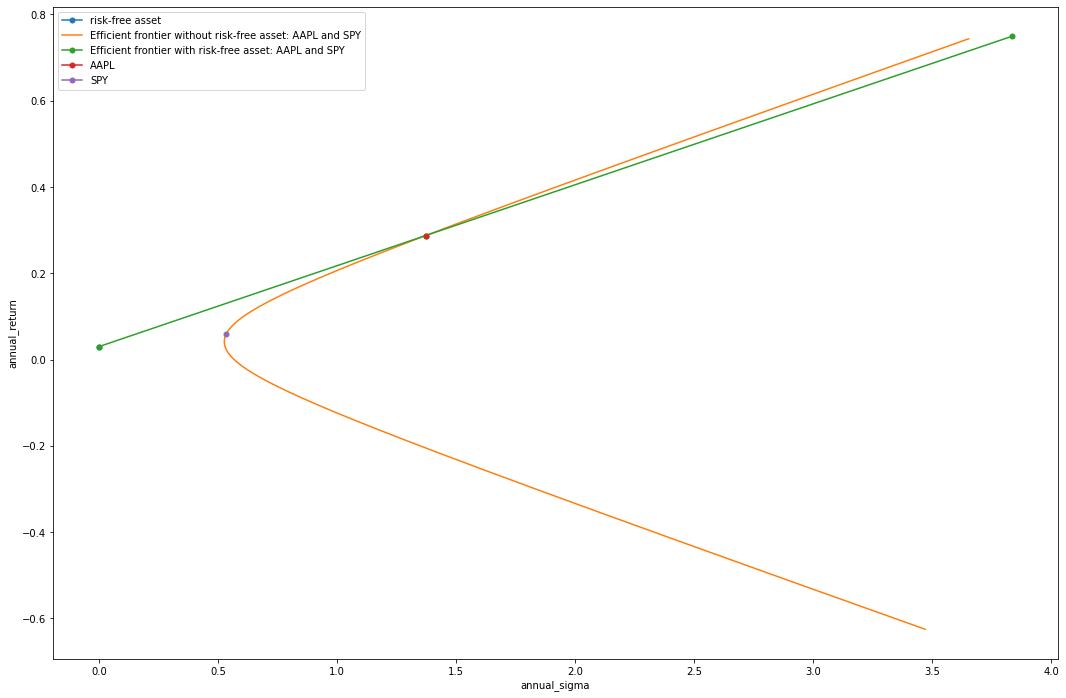

In [6]:
fig, ax = plt.subplots(figsize=(18,12))
best_alpha, best_slope, best_portfolio, ax, fig = portfolio_plot(apple, spy, cov, ax, fig)

In [7]:
print(best_alpha, best_slope)
print(best_portfolio)

1.0 0.1875240689068333
{'annual_return': 0.2871792038503452, 'annual_sigma': 1.3714463713888287, 'name': 'AAPL_SPY', 'returns_per_period': period
2000-01   -0.010728
2000-02    0.102165
2000-03    0.145493
2000-04   -0.084409
2000-05   -0.327327
             ...   
2022-04   -0.094122
2022-05   -0.048825
2022-06   -0.087925
2022-07    0.194575
2022-08   -0.011672
Freq: M, Length: 272, dtype: float64, 'num_periods': 12}


# Add Google

In [8]:
google = get_stock_info('GOOG', start='2000-01-01', end='2022-08-31')
cov = get_cov(best_portfolio,google)
get_analytical_sol(best_portfolio, google)

(0.37504725247028764, 0.2348240215602416)

In [9]:
best_alpha, best_slope, best_portfolio, ax, fig = portfolio_plot(best_portfolio, google, cov, ax, fig)

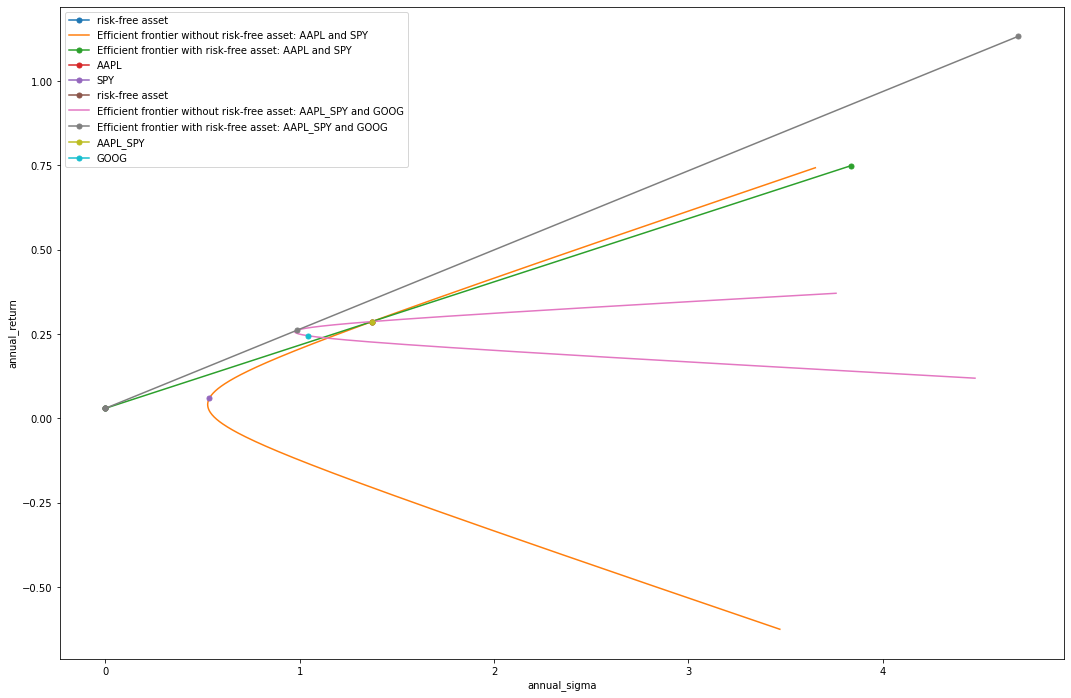

In [10]:
fig

In [11]:
best_alpha, best_slope

(0.3799999999999999, 0.23481883676336537)

# Add Crude Oil

In [12]:
crude_oil = get_stock_info('CL', start='2000-01-01', end='2022-08-31')
cov = get_cov(best_portfolio ,crude_oil)
get_analytical_sol(best_portfolio, crude_oil)

(0.7805144558868428, 0.23773199661681652)

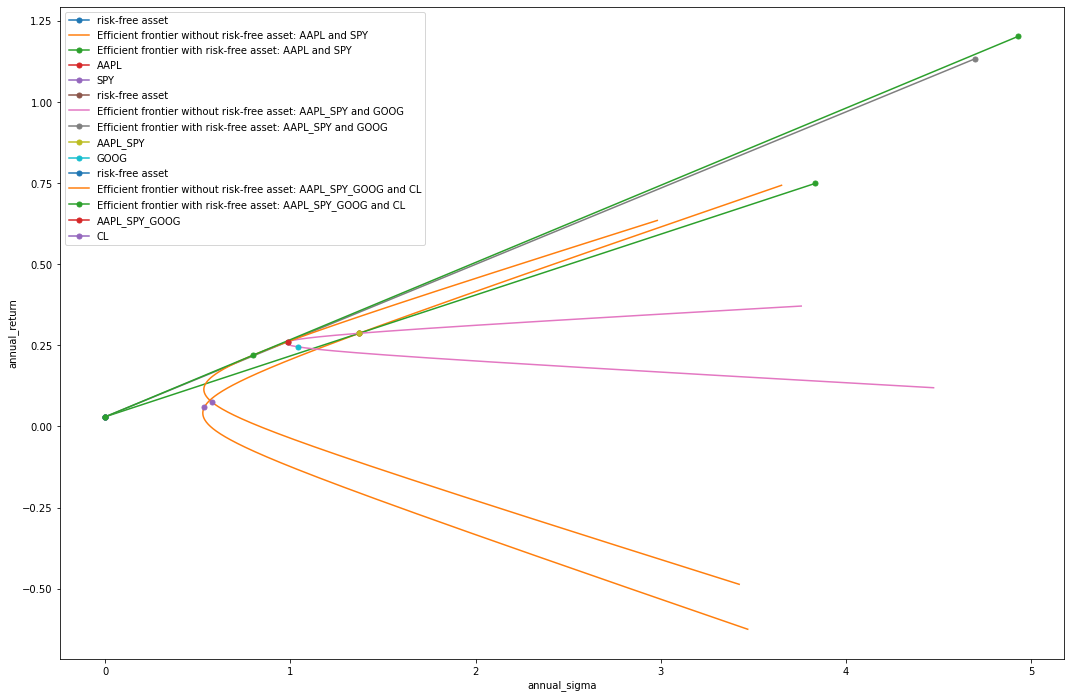

In [13]:
best_alpha, best_slope, best_portfolio, ax, fig = portfolio_plot(best_portfolio, crude_oil, cov, ax, fig)
fig

In [14]:
print(best_alpha, best_slope)

0.7800000000000002 0.2377319724947813


# Add Bitcoin

In [15]:
btc = get_stock_info('BTC-USD', start='2000-01-01', end='2022-08-31')
cov = get_cov(best_portfolio ,btc)
get_analytical_sol(best_portfolio, btc)

(0.7405002013083097, 0.3210329585322392)

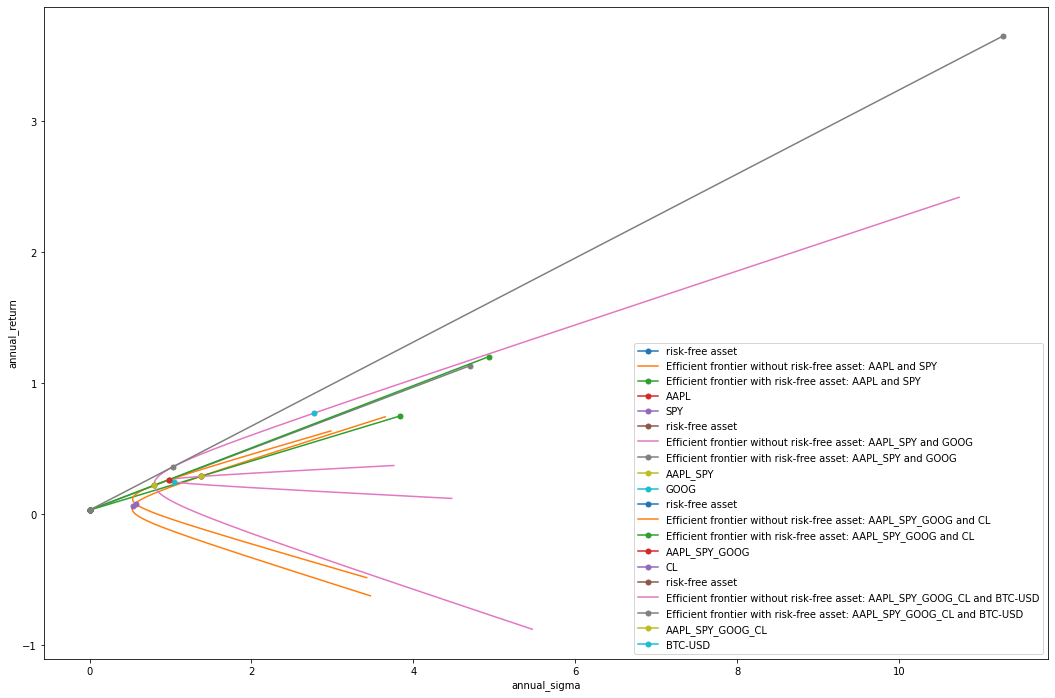

In [16]:
best_alpha, best_slope, best_portfolio, ax, fig = portfolio_plot(best_portfolio, btc, cov, ax, fig)
fig

In [17]:
print(best_alpha, best_slope)

0.7400000000000002 0.3210327986493874


# Add HOOD

In [18]:
hood = get_stock_info('HOOD', start='2000-01-01', end='2022-08-31')
hood['num_periods'] = 12
get_analytical_sol(best_portfolio, hood)

AAPL_SPY_GOOG_CL_BTC-USD dominates HOOD


AssertionError: None

# HOOD + GOOGLE + UBER

In [19]:
get_analytical_sol(google, hood)

GOOG dominates HOOD


AssertionError: None

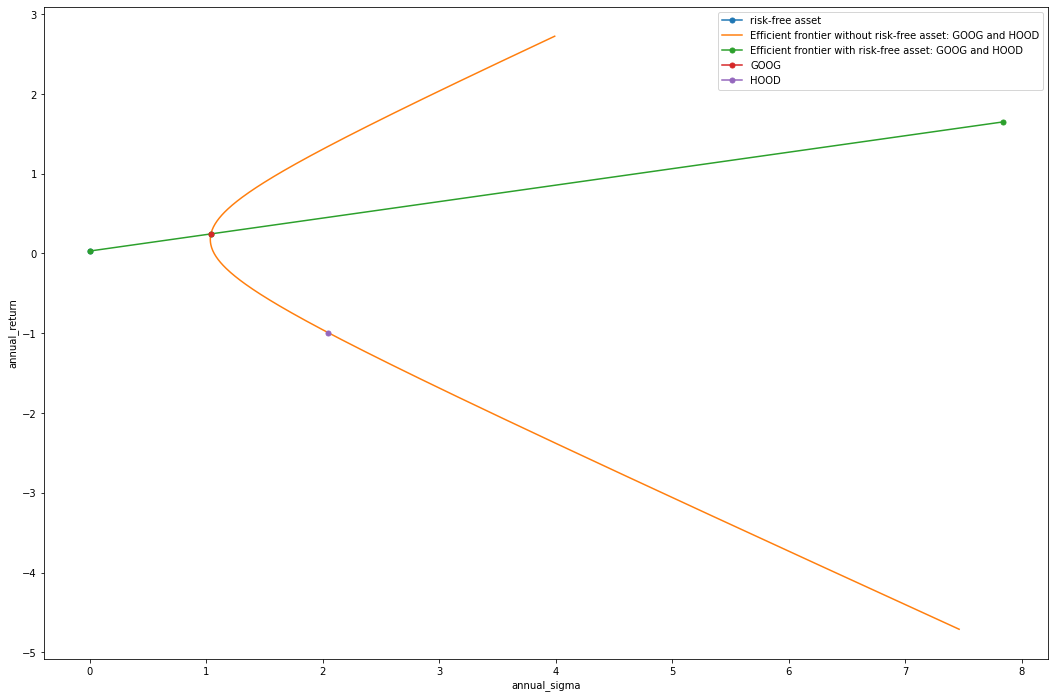

In [20]:
fig, ax = plt.subplots(figsize=(18,12))
cov = get_cov(google,hood)
best_alpha, best_slope, best_portfolio, ax, fig = portfolio_plot(google, hood, cov, ax, fig)

In [23]:
uber = get_stock_info('UBER', start='2000-01-01', end='2022-08-31')
get_analytical_sol(uber, hood)

UBER dominates HOOD


AssertionError: None

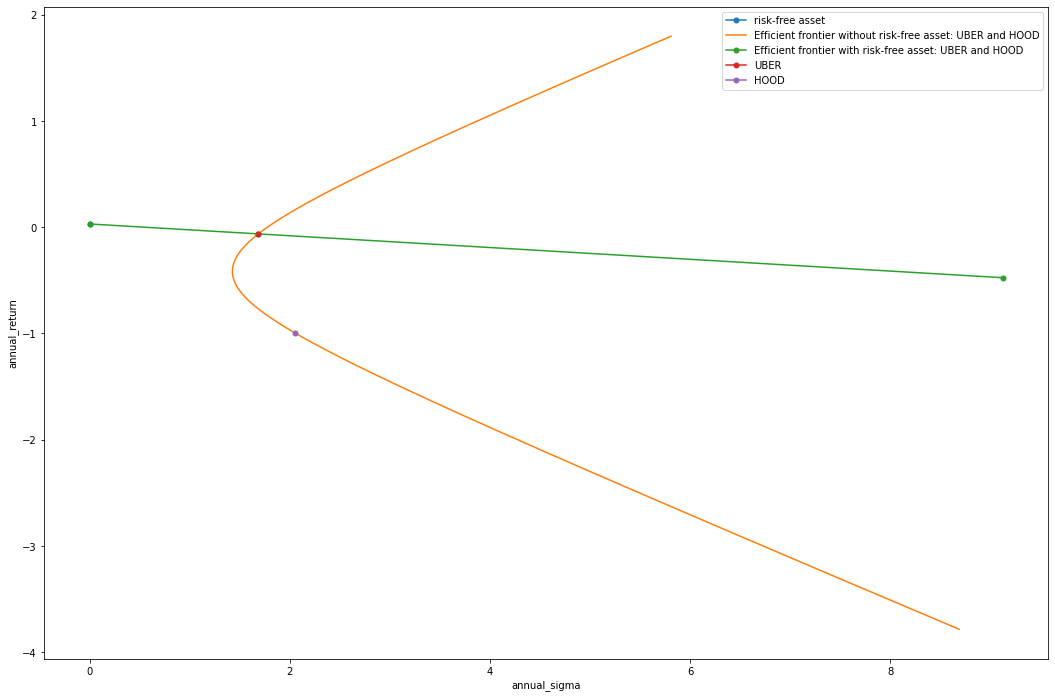

In [24]:
fig, ax = plt.subplots(figsize=(18,12))
cov = get_cov(uber,hood)
best_alpha, best_slope, best_portfolio, ax, fig = portfolio_plot(uber, hood, cov, ax, fig)

In [25]:
get_analytical_sol(google, uber)

GOOG dominates UBER


AssertionError: None